In [1]:
import sys
sys.path.append("..")
import logging
import os
from collections import OrderedDict, defaultdict

import hydra
from hydra import initialize, compose
import torch
import wandb
from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
from torch.cuda import amp
from torch.nn import SyncBatchNorm
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm

import detectron2.utils.comm as d2_comm
from detectron2.data.catalog import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import DatasetEvaluators, inference_on_dataset
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import CommonMetricPrinter, get_event_storage

import tridet.modeling  # pylint: disable=unused-import
import tridet.utils.comm as comm
from tridet.data import build_test_dataloader, build_train_dataloader
from tridet.data.dataset_mappers import get_dataset_mapper
from tridet.data.datasets import random_sample_dataset_dicts, register_datasets
from tridet.evaluators import get_evaluator
from tridet.modeling import build_tta_model
from tridet.utils.s3 import sync_output_dir_s3
from tridet.utils.setup import setup
from tridet.utils.train import get_inference_output_dir, print_test_results
from tridet.utils.visualization import mosaic, save_vis
from tridet.utils.wandb import flatten_dict, log_nested_dict
from tridet.visualizers import get_dataloader_visualizer, get_predictions_visualizer

# from tridet.data.datasets.kitti_3d import register_kitti_3d_datasets
from tridet.data.datasets.custom import register_kitti_3d_datasets
from tridet.data.datasets.nuscenes import register_nuscenes_datasets

In [2]:
LOG = logging.getLogger("tridet")
CFG_PATH = "../configs/"
CFG_NAME = "kitti99_defaults"
CHECKPOINT = "../models/kitti_v99.pth"

DATASET = "inference"

In [3]:
with initialize(config_path=CFG_PATH):
    cfg = compose(config_name=CFG_NAME)

In [4]:
setup(cfg)

In [5]:
dataset_name = register_kitti_3d_datasets([DATASET], cfg)[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]
Using previously cached COCO format annotations at '/tmp/inference_coco_format.json'. You need to clear the cache file if your dataset has been modified.


In [6]:
dataset_dicts = DatasetCatalog.get(DATASET)

In [7]:
print(dataset_dicts[0])
#for i in dataset_dicts:
#    if i['intrinsics'][0] != 721.5377:
#        print(i)
#        break
print(dataset_dicts[3])

{'intrinsics': [721.5377, 0.0, 609.5593, 0.0, 721.5377, 172.854, 0.0, 0.0, 1.0], 'file_name': '/workspace/dd3d/datasets/KITTI3D/inference/image_2/a1.jpg', 'width': 1280, 'height': 384, 'image_id': 'a1_camera_2', 'sample_id': 'a1', 'extrinsics': {'wxyz': [0.5052849217866479, -0.4947772602255061, 0.4999698353195917, -0.49991276673966156], 'tvec': [0.2756594908080122, -0.06181862762075632, -0.07253154657979646]}}
{'intrinsics': [721.5377, 0.0, 609.5593, 0.0, 721.5377, 172.854, 0.0, 0.0, 1.0], 'file_name': '/workspace/dd3d/datasets/KITTI3D/inference/image_2/a4.jpg', 'width': 1280, 'height': 384, 'image_id': 'a4_camera_2', 'sample_id': 'a4', 'extrinsics': {'wxyz': [0.5052849217866479, -0.4947772602255061, 0.4999698353195917, -0.49991276673966156], 'tvec': [0.2756594908080122, -0.06181862762075632, -0.07253154657979646]}}


In [8]:
model = build_model(cfg)
_ = Checkpointer(model).load(CHECKPOINT)

In [9]:
mapper = get_dataset_mapper(cfg, is_train=False)
dataloader, dataset_dicts = build_test_dataloader(cfg, dataset_name, mapper)

In [10]:
a = per_dataset_results = inference_on_dataset(model, dataloader, evaluator=None)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
from contextlib import ExitStack, contextmanager
from torch import nn

with torch.no_grad(): 
    model.eval()
    final_inputs = []
    final_outputs = []
    for idx, inputs in enumerate(dataloader):
        outputs = model(inputs)
        final_inputs.extend(inputs)
        final_outputs.extend(outputs)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


a1

Score: 0.82
pixel center: x=-2px; y=248px;
pixel_corners: [(-199, 182), (-47, 182), (-47, 300), (-200, 323), (56, 182), (177, 181), (177, 309), (56, 336)]
dimensions: width=1.53m; length=3.46m; height=1.55m
angles: roty=-2.93; alpha=-2.23
center: x=-7.12m;y=1.66m; depth=8.39m
corners: [(-8.97, 0.1, 8.01), (-8.65, 0.11, 9.51), (-8.65, 1.67, 9.5), (-8.97, 1.66, 8.0), (-5.59, 0.09, 7.29), (-5.27, 0.1, 8.79), (-5.26, 1.65, 8.77), (-5.58, 1.64, 7.27)]

Score: 0.81
pixel center: x=225px; y=305px;
pixel_corners: [(-16, 209), (191, 201), (191, 346), (-15, 390), (286, 229), (483, 213), (484, 408), (286, 495)]
dimensions: width=1.56m; length=3.54m; height=1.37m
angles: roty=-2.62; alpha=-2.13
center: x=-2.81m;y=1.65m; depth=5.26m
corners: [(-4.73, 0.28, 5.46), (-3.95, 0.27, 6.81), (-3.95, 1.64, 6.82), (-4.73, 1.65, 5.47), (-1.66, 0.29, 3.7), (-0.88, 0.28, 5.05), (-0.88, 1.65, 5.06), (-1.66, 1.66, 3.7)]



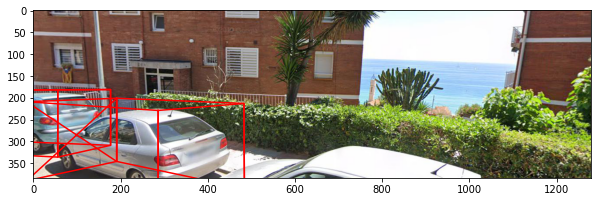

a2

Score: 0.90
pixel center: x=1071px; y=286px;
pixel_corners: [(1022, 211), (857, 203), (858, 371), (1024, 429), (1287, 199), (1101, 194), (1102, 333), (1288, 370)]
dimensions: width=1.48m; length=3.14m; height=1.40m
angles: roty=2.73; alpha=2.16
center: x=3.78m;y=1.62m; depth=5.92m
corners: [(2.63, 0.24, 4.6), (2.04, 0.25, 5.96), (2.06, 1.64, 5.96), (2.65, 1.64, 4.61), (5.51, 0.21, 5.87), (4.91, 0.21, 7.22), (4.93, 1.61, 7.22), (5.52, 1.6, 5.87)]



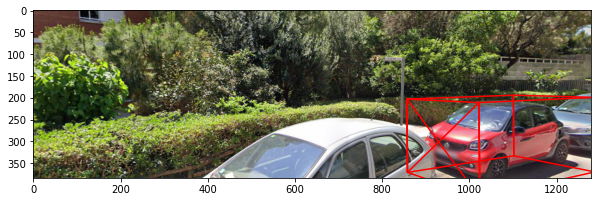

a3

Score: 0.90
pixel center: x=481px; y=156px;
pixel_corners: [(464, 138), (430, 138), (430, 177), (465, 178), (527, 138), (496, 137), (496, 171), (527, 173)]
dimensions: width=1.65m; length=4.41m; height=1.52m
angles: roty=2.03; alpha=2.2
center: x=-5.29m;y=0.07m; depth=29.82m
corners: [(-5.52, -1.31, 27.45), (-7.01, -1.36, 28.17), (-7.01, 0.15, 28.26), (-5.53, 0.2, 27.53), (-3.57, -1.53, 31.39), (-5.05, -1.58, 32.12), (-5.06, -0.06, 32.21), (-3.58, -0.01, 31.48)]

Score: 0.86
pixel center: x=384px; y=167px;
pixel_corners: [(366, 144), (321, 144), (321, 194), (367, 196), (439, 144), (399, 143), (399, 186), (439, 188)]
dimensions: width=1.60m; length=3.95m; height=1.50m
angles: roty=1.88; alpha=2.19
center: x=-7.21m;y=0.57m; depth=23.07m
corners: [(-7.05, -0.83, 20.92), (-8.57, -0.87, 21.41), (-8.59, 0.63, 21.48), (-7.06, 0.67, 20.99), (-5.84, -1.0, 24.68), (-7.36, -1.03, 25.17), (-7.37, 0.47, 25.24), (-5.85, 0.51, 24.75)]

Score: 0.75
pixel center: x=879px; y=149px;
pixel_corners: [(

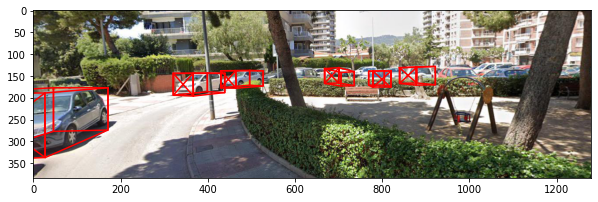

a4

Score: 0.90
pixel center: x=1089px; y=188px;
pixel_corners: [(1002, 151), (1084, 149), (1084, 215), (1003, 216), (1096, 154), (1206, 151), (1205, 239), (1096, 239)]
dimensions: width=1.57m; length=3.70m; height=1.37m
angles: roty=-1.43; alpha=-2.02
center: x=8.74m;y=0.97m; depth=13.16m
corners: [(8.21, -0.46, 15.07), (9.76, -0.49, 14.85), (9.8, 0.87, 14.9), (8.24, 0.9, 15.13), (7.69, -0.31, 11.41), (9.24, -0.34, 11.19), (9.28, 1.03, 11.24), (7.72, 1.06, 11.46)]

Score: 0.85
pixel center: x=927px; y=152px;
pixel_corners: [(883, 133), (926, 132), (926, 168), (883, 169), (929, 133), (981, 132), (981, 175), (929, 177)]
dimensions: width=1.63m; length=4.53m; height=1.40m
angles: roty=-1.52; alpha=-1.94
center: x=11.22m;y=-0.02m; depth=25.46m
corners: [(10.49, -1.53, 27.73), (12.12, -1.57, 27.65), (12.16, -0.17, 27.73), (10.53, -0.14, 27.8), (10.28, -1.28, 23.21), (11.91, -1.31, 23.13), (11.94, 0.08, 23.21), (10.31, 0.12, 23.29)]

Score: 0.83
pixel center: x=994px; y=167px;
pixel_corners

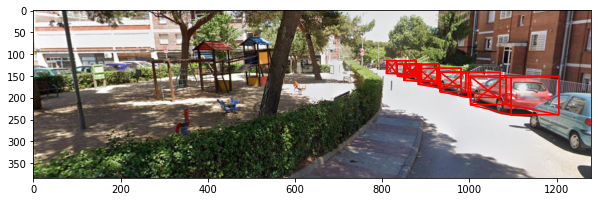

b1



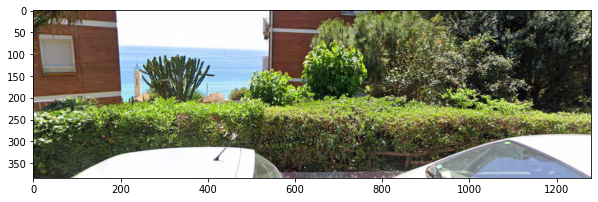

b2

Score: 0.90
pixel center: x=654px; y=181px;
pixel_corners: [(663, 137), (560, 137), (562, 241), (664, 247), (729, 134), (648, 134), (648, 213), (729, 217)]
dimensions: width=1.55m; length=3.57m; height=1.50m
angles: roty=1.98; alpha=1.92
center: x=0.73m;y=0.89m; depth=11.69m
corners: [(0.72, -0.49, 9.69), (-0.7, -0.51, 10.31), (-0.69, 0.98, 10.41), (0.73, 1.01, 9.79), (2.15, -0.71, 12.97), (0.72, -0.73, 13.58), (0.73, 0.76, 13.68), (2.16, 0.79, 13.06)]

Score: 0.82
pixel center: x=517px; y=230px;
pixel_corners: [(510, 164), (358, 165), (362, 330), (513, 344), (630, 156), (519, 157), (521, 270), (631, 276)]
dimensions: width=1.43m; length=2.95m; height=1.40m
angles: roty=1.92; alpha=2.05
center: x=-0.93m;y=1.27m; depth=7.24m
corners: [(-0.77, -0.07, 5.58), (-2.12, -0.07, 6.07), (-2.1, 1.33, 6.13), (-0.75, 1.34, 5.64), (0.23, -0.2, 8.35), (-1.12, -0.2, 8.84), (-1.09, 1.2, 8.9), (0.25, 1.2, 8.41)]

Score: 0.77
pixel center: x=1018px; y=133px;
pixel_corners: [(991, 113), (952, 114), (9

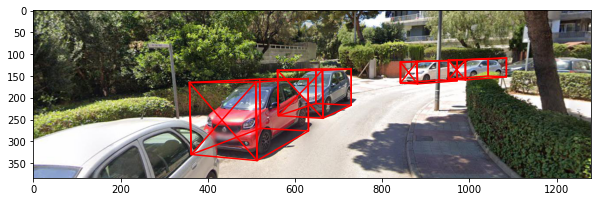

b3

Score: 0.81
pixel center: x=351px; y=121px;
pixel_corners: [(305, 100), (347, 101), (347, 139), (305, 140), (355, 100), (400, 102), (400, 145), (355, 145)]
dimensions: width=1.67m; length=4.05m; height=1.52m
angles: roty=-2.37; alpha=-2.03
center: x=-9.53m;y=-1.14m; depth=26.57m
corners: [(-11.54, -2.78, 27.33), (-10.37, -2.84, 28.52), (-10.42, -1.33, 28.65), (-11.59, -1.27, 27.45), (-8.64, -2.46, 24.51), (-7.47, -2.52, 25.71), (-7.52, -1.01, 25.83), (-8.69, -0.95, 24.63)]

Score: 0.76
pixel center: x=255px; y=133px;
pixel_corners: [(291, 113), (239, 112), (240, 156), (292, 156), (269, 112), (221, 111), (221, 151), (269, 151)]
dimensions: width=1.52m; length=3.22m; height=1.38m
angles: roty=0.92; alpha=1.38
center: x=-11.83m;y=-0.65m; depth=24.08m
corners: [(-10.23, -1.92, 23.21), (-11.44, -1.89, 22.29), (-11.48, -0.52, 22.39), (-10.27, -0.55, 23.31), (-12.18, -2.16, 25.76), (-13.38, -2.13, 24.85), (-13.42, -0.76, 24.95), (-12.22, -0.79, 25.86)]

Score: 0.74
pixel center: x=303px; 

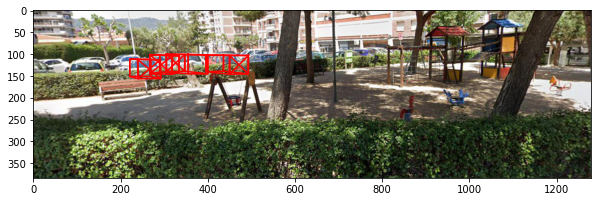

b4

Score: 0.89
pixel center: x=460px; y=133px;
pixel_corners: [(409, 108), (460, 108), (460, 152), (409, 154), (461, 110), (519, 110), (519, 162), (461, 164)]
dimensions: width=1.60m; length=4.26m; height=1.36m
angles: roty=-2.14; alpha=-1.94
center: x=-4.19m;y=-0.43m; depth=20.23m
corners: [(-6.0, -1.94, 21.53), (-4.66, -2.0, 22.39), (-4.67, -0.64, 22.51), (-6.02, -0.58, 21.66), (-3.7, -1.58, 17.96), (-2.36, -1.64, 18.81), (-2.38, -0.28, 18.94), (-3.72, -0.22, 18.08)]

Score: 0.88
pixel center: x=639px; y=179px;
pixel_corners: [(562, 130), (647, 129), (646, 212), (563, 216), (630, 133), (736, 132), (735, 240), (630, 247)]
dimensions: width=1.50m; length=3.06m; height=1.43m
angles: roty=-1.92; alpha=-1.96
center: x=0.45m;y=0.81m; depth=10.75m
corners: [(-0.78, -0.71, 11.88), (0.64, -0.75, 12.38), (0.64, 0.68, 12.49), (-0.78, 0.72, 11.99), (0.25, -0.5, 9.01), (1.67, -0.54, 9.51), (1.67, 0.89, 9.62), (0.25, 0.93, 9.12)]

Score: 0.88
pixel center: x=401px; y=123px;
pixel_corners: [(355, 

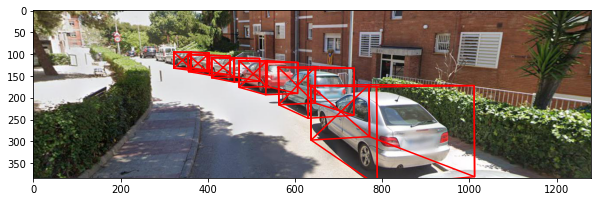

c1



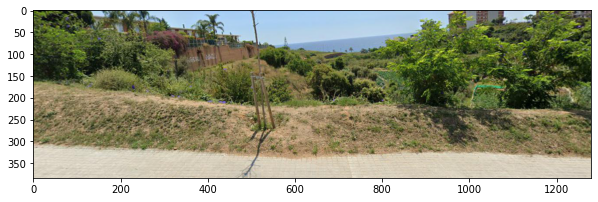

c2

Score: 0.88
pixel center: x=837px; y=133px;
pixel_corners: [(795, 111), (842, 110), (842, 152), (795, 153), (830, 110), (886, 109), (886, 159), (830, 161)]
dimensions: width=1.61m; length=4.05m; height=1.45m
angles: roty=-1.57; alpha=-1.87
center: x=7.13m;y=-0.53m; depth=22.69m
corners: [(6.32, -2.12, 24.65), (7.93, -2.16, 24.64), (7.97, -0.72, 24.76), (6.36, -0.68, 24.77), (6.3, -1.79, 20.62), (7.91, -1.83, 20.6), (7.94, -0.39, 20.72), (6.33, -0.35, 20.74)]

Score: 0.84
pixel center: x=926px; y=168px;
pixel_corners: [(863, 135), (932, 134), (931, 194), (863, 195), (918, 136), (1004, 134), (1003, 210), (918, 211)]
dimensions: width=1.58m; length=3.40m; height=1.41m
angles: roty=-1.52; alpha=-1.94
center: x=6.67m;y=0.61m; depth=15.25m
corners: [(5.95, -0.89, 16.94), (7.53, -0.92, 16.87), (7.56, 0.49, 16.95), (5.98, 0.52, 17.02), (5.79, -0.69, 13.55), (7.37, -0.72, 13.48), (7.4, 0.69, 13.56), (5.82, 0.72, 13.63)]

Score: 0.83
pixel center: x=1134px; y=232px;
pixel_corners: [(1417, 18

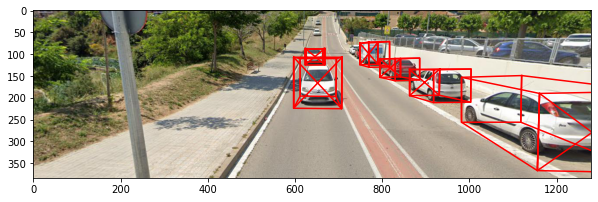

c3

Score: 0.78
pixel center: x=858px; y=268px;
pixel_corners: [(578, 179), (652, 179), (651, 316), (578, 350), (1225, 183), (1154, 181), (1154, 363), (1225, 428)]
dimensions: width=1.57m; length=4.12m; height=1.38m
angles: roty=-2.7; alpha=-3.03
center: x=1.94m;y=1.44m; depth=5.66m
corners: [(-0.25, 0.05, 5.83), (0.42, 0.06, 7.25), (0.42, 1.44, 7.25), (-0.26, 1.43, 5.82), (3.47, 0.06, 4.07), (4.14, 0.06, 5.49), (4.14, 1.45, 5.48), (3.46, 1.44, 4.06)]

Score: 0.75
pixel center: x=-71px; y=264px;
pixel_corners: [(-229, 185), (-501, 182), (-500, 430), (-229, 431), (157, 175), (14, 174), (14, 306), (156, 307)]
dimensions: width=1.57m; length=3.76m; height=1.46m
angles: roty=1.55; alpha=2.31
center: x=-5.80m;y=1.50m; depth=6.15m
corners: [(-4.97, 0.07, 4.28), (-6.53, 0.05, 4.25), (-6.55, 1.52, 4.26), (-4.99, 1.53, 4.29), (-5.04, 0.03, 8.04), (-6.61, 0.01, 8.01), (-6.63, 1.47, 8.02), (-5.06, 1.49, 8.05)]

Score: 0.68
pixel center: x=361px; y=267px;
pixel_corners: [(552, 189), (586, 187), (5

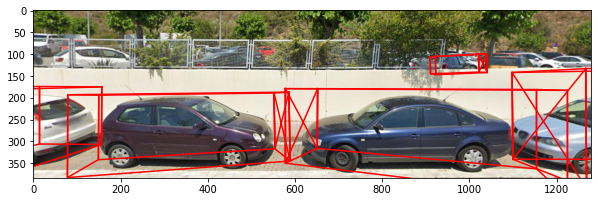

c4

Score: 0.91
pixel center: x=531px; y=133px;
pixel_corners: [(551, 107), (491, 106), (491, 165), (550, 166), (566, 106), (516, 105), (515, 156), (566, 157)]
dimensions: width=1.50m; length=3.27m; height=1.48m
angles: roty=1.63; alpha=1.74
center: x=-2.12m;y=-0.33m; depth=19.60m
corners: [(-1.45, -1.64, 17.87), (-2.95, -1.67, 17.95), (-2.98, -0.2, 18.1), (-1.48, -0.16, 18.01), (-1.26, -1.95, 21.12), (-2.76, -1.99, 21.21), (-2.79, -0.51, 21.35), (-1.29, -0.48, 21.27)]

Score: 0.91
pixel center: x=422px; y=140px;
pixel_corners: [(432, 111), (366, 109), (366, 176), (432, 178), (468, 110), (413, 109), (412, 164), (467, 166)]
dimensions: width=1.52m; length=3.38m; height=1.53m
angles: roty=1.61; alpha=1.87
center: x=-4.72m;y=-0.05m; depth=18.10m
corners: [(-4.01, -1.4, 16.31), (-5.52, -1.46, 16.37), (-5.57, 0.07, 16.51), (-4.05, 0.12, 16.45), (-3.87, -1.71, 19.68), (-5.38, -1.76, 19.74), (-5.43, -0.23, 19.87), (-3.91, -0.18, 19.81)]

Score: 0.89
pixel center: x=308px; y=185px;
pixel_corne

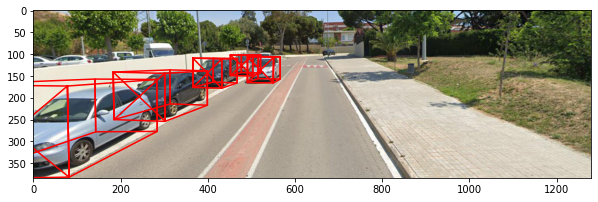

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
from tridet.evaluators.kitti_3d_evaluator import convert_3d_box_to_kitti
from tridet.utils.geometry import project_points3d
plt.rcParams['figure.figsize'] = [10, 5]

for inp, outp in zip(final_inputs, final_outputs):
    print(inp["sample_id"])
    #print(inp['intrinsics'])
    print()
    outp = outp["instances"].get_fields()
    
    scores = outp["scores_3d"]
    count = len([score for score in scores if score > 0.5])
    boxes = outp["pred_boxes"][:count]
    boxes_3d = outp["pred_boxes3d"][:count]
    locations = outp["locations"][:count]
    scores = scores[:count]
    
    for location, box, box_3d, score in zip(locations, boxes, boxes_3d, scores):
        
        kitti_format = convert_3d_box_to_kitti(box_3d)
        w, l, h, x, y, z, roty, alpha = [round(item, 2) for item in kitti_format]
        dimensions = (w, l, h)
        location = (x, y, z)
        angles = (roty, alpha)
        
        corners = box_3d.corners.cpu().numpy()[0].tolist()
        corners = [(round(c1, 2), round(c2, 2), round(c3, 2)) for c1, c2, c3 in corners]
        
        center_px = box_3d.proj_ctr.cpu().numpy()[0].tolist()
        center_px = (round(center_px[0]), round(center_px[1]))
        
        corners_px = project_points3d(box_3d.corners.cpu().numpy()[0], inp["intrinsics"].numpy()).tolist()
        corners_px = [(round(c1), round(c2)) for c1, c2 in corners_px]
        
        print(f"Score: {score:.2f}")
        print(f"pixel center: x={center_px[0]:.0f}px; y={center_px[1]:.0f}px;")
        print("pixel_corners:", corners_px)
        print(f"dimensions: width={w:.2f}m; length={l:.2f}m; height={h:.2f}m")
        print(f"angles: roty={roty}; alpha={alpha}")
        print(f"center: x={x:.2f}m;y={y:.2f}m; depth={z:.2f}m")
        print("corners:", corners)
        print()
        #print("quat:", box_3d.quat.cpu().numpy()[0])
        #print("depth:", box_3d.depth.cpu().numpy()[0])
        #print("size:", box_3d.size.cpu().numpy()[0])
        #print("tvec:", box_3d.tvec.cpu().numpy()[0])
        
        # front top left, front top right, front bottom right, front bottom left
        # back top left, back top right, back bottom right, back bottom left
        
        # box = box.cpu()
        # plt.gca().add_patch(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none'))
        for a, b, c, d in [(0, 1, 2, 3), (4, 5, 6, 7), (0, 4, 7, 3), (1, 5, 6, 2), (0, 2, 1, 3)]:
            coord = [corners_px[a], corners_px[b], corners_px[c], corners_px[d], corners_px[a]] 
            xs, ys = zip(*coord)
            plt.plot(xs, ys, color='r')
        
    img = Image.open(inp["file_name"])
    plt.imshow(img)
    plt.show()